Data loaded successfully.

Generating Exploratory Visualizations...


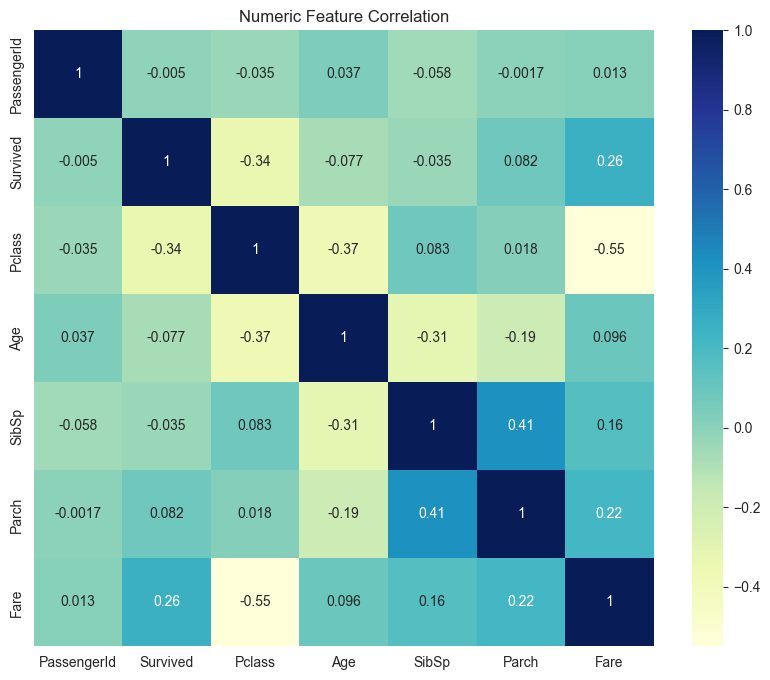

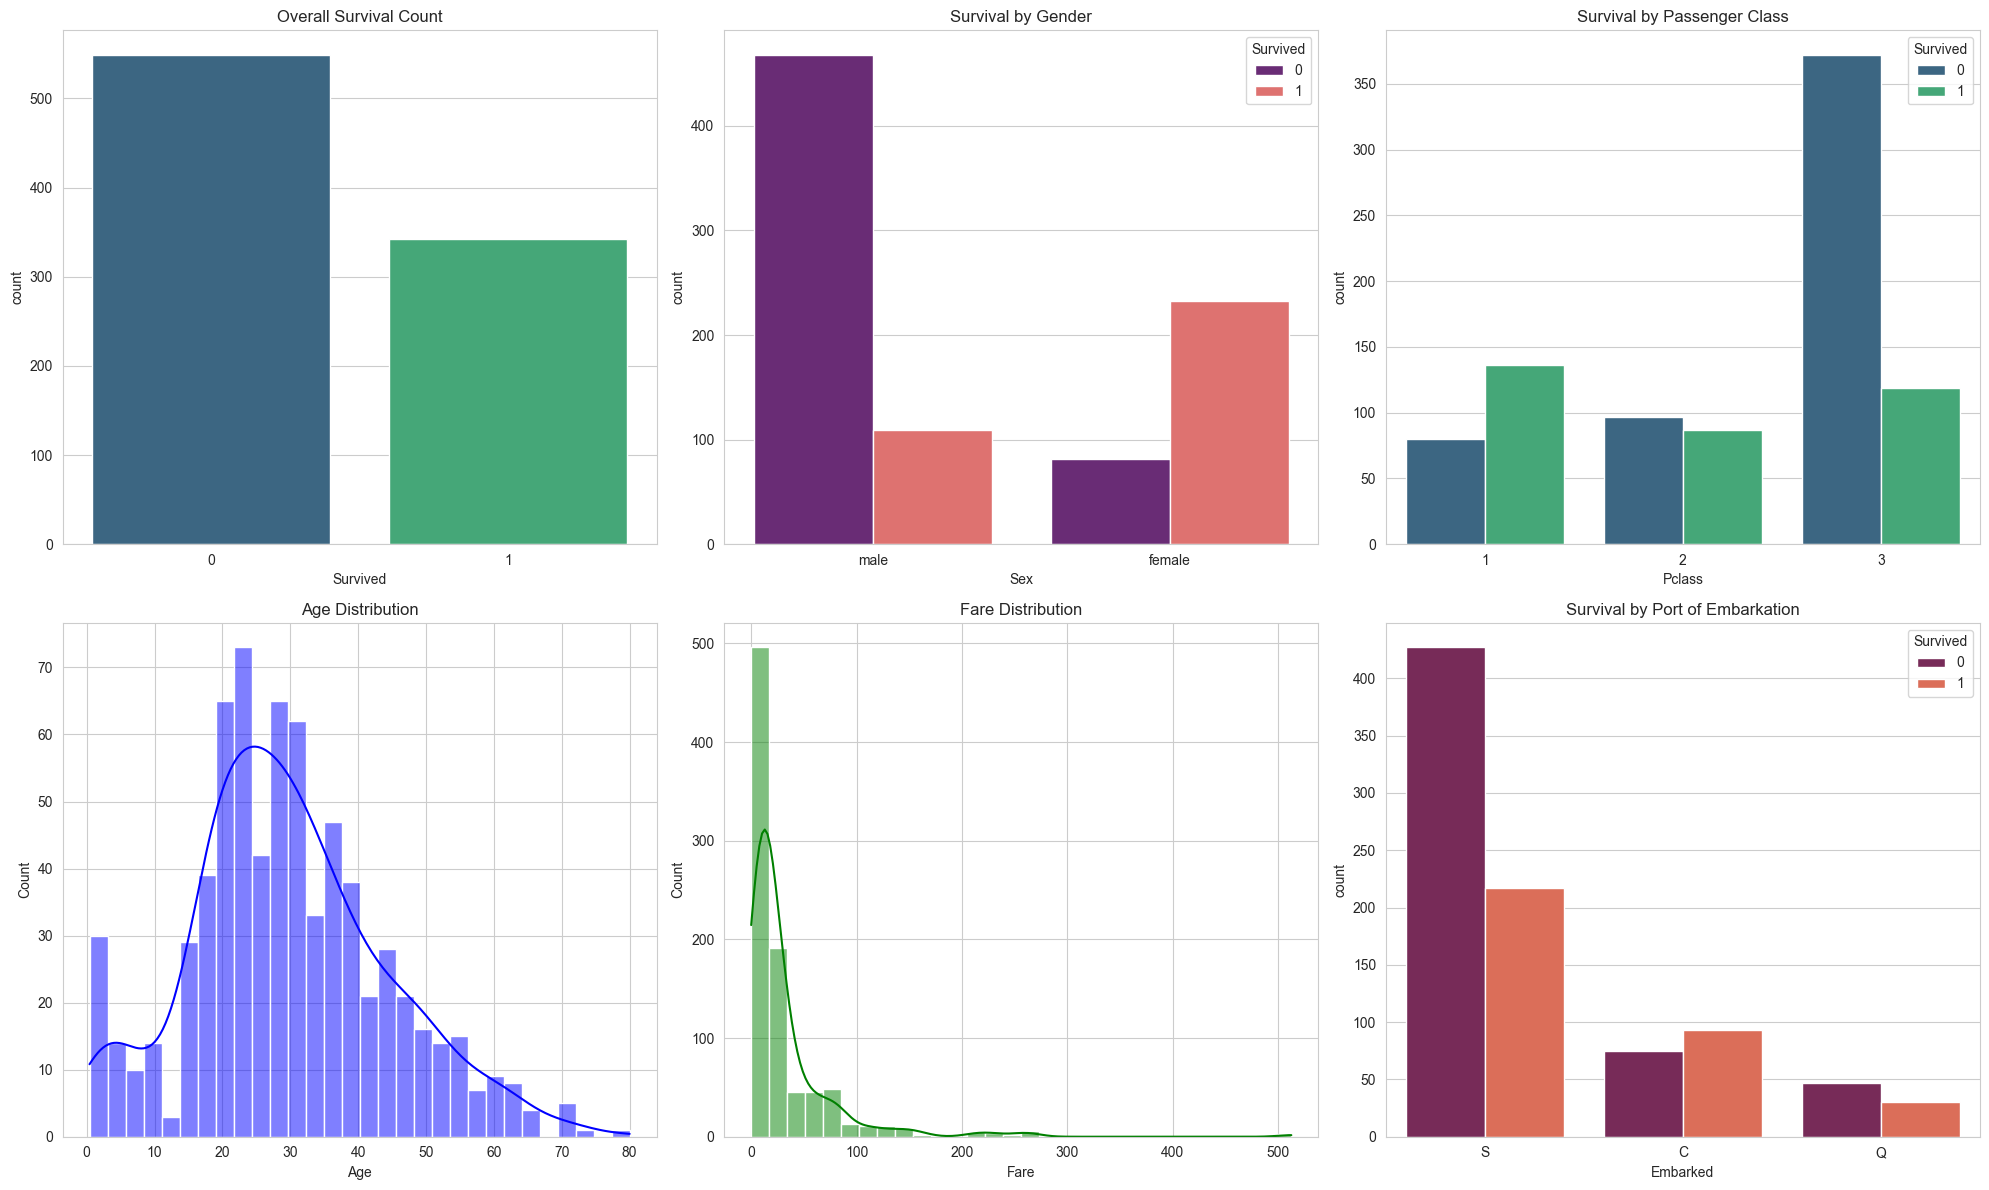


Model Comparison Table:
                 Model  Accuracy  CV Score  F1 Score
0  Logistic Regression  0.860335  0.816074  0.812030
2    Gradient Boosting  0.832402  0.811868  0.765625
3                  SVM  0.826816  0.823047  0.755906
1        Random Forest  0.821229  0.797853  0.761194
5              XGBoost  0.815642  0.788004  0.759124
4                  KNN  0.759777  0.796356  0.676692

Tuning best model: Logistic Regression...
Best Params: {'C': 0.1}


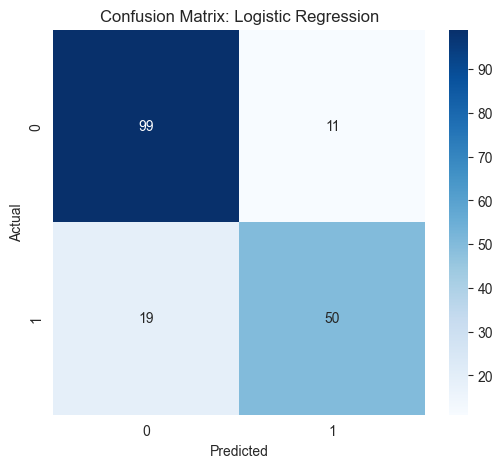

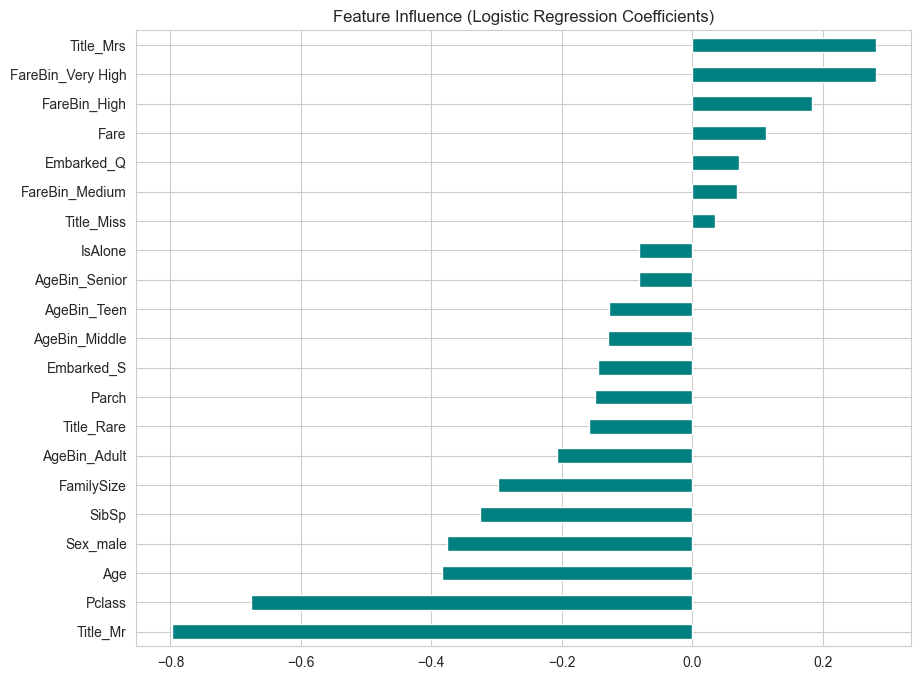


Generating final submission file...
Project Complete! Submission file saved as '../output/submission.csv'.


In [34]:
# ============================================================================
# TITANIC SURVIVAL PREDICTION: COMPLETE FINAL WORKFLOW
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings
import os

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create output directory if it doesn't exist
if not os.path.exists('../output'):
    os.makedirs('../output')

# ============================================================================
# 1. LOAD DATA
# ============================================================================
try:
    train_df = pd.read_csv("../data/train.csv")
    test_df = pd.read_csv("../data/test.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: CSV files not found. Check your '../data/' folder.")

# ============================================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\nGenerating Exploratory Visualizations...")

# A. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.select_dtypes(include=[np.number]).corr(), cmap="YlGnBu", annot=True)
plt.title("Numeric Feature Correlation")
plt.show()

# B. 6-Plot Dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

sns.countplot(data=train_df, x='Survived', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Overall Survival Count')

sns.countplot(data=train_df, x='Sex', hue='Survived', ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Survival by Gender')

sns.countplot(data=train_df, x='Pclass', hue='Survived', ax=axes[0, 2], palette='viridis')
axes[0, 2].set_title('Survival by Passenger Class')

sns.histplot(train_df['Age'].dropna(), bins=30, ax=axes[1, 0], kde=True, color='blue')
axes[1, 0].set_title('Age Distribution')

sns.histplot(train_df['Fare'], bins=30, ax=axes[1, 1], kde=True, color='green')
axes[1, 1].set_title('Fare Distribution')

sns.countplot(data=train_df, x='Embarked', hue='Survived', ax=axes[1, 2], palette='rocket')
axes[1, 2].set_title('Survival by Port of Embarkation')

plt.tight_layout()
plt.show()

# ============================================================================
# 3. DATA PREPROCESSING & FEATURE ENGINEERING
# ============================================================================

def preprocess_data(df):
    df = df.copy()
    # Title Extraction
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
                     'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Dona': 'Rare'}
    df['Title'] = df['Title'].map(title_mapping).fillna('Rare')
    
    # Family Features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Imputation
    df['Age'] = df.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Binning
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 100], labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    
    df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, errors='ignore', inplace=True)
    return df

train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)

# One-Hot Encoding
categorical_cols = ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin']
train_processed['is_test'] = 0
test_processed['is_test'] = 1
combined = pd.get_dummies(pd.concat([train_processed, test_processed]), columns=categorical_cols, drop_first=True)

X = combined[combined['is_test'] == 0].drop(['is_test', 'Survived'], axis=1)
y = train_df['Survived']
X_test_final = combined[combined['is_test'] == 1].drop(['is_test', 'Survived'], axis=1)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_final_scaled = scaler.transform(X_test_final)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# ============================================================================
# 4. MODEL BUILDING & 5. EVALUATION
# ============================================================================

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    cv_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    results.append({'Model': name, 'Accuracy': accuracy_score(y_val, y_pred), 'CV Score': cv_score, 'F1 Score': f1_score(y_val, y_pred)})

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nModel Comparison Table:")
print(results_df)

# ============================================================================
# 6. HYPERPARAMETER TUNING
# ============================================================================
best_model_name = results_df.iloc[0]['Model']
print(f"\nTuning best model: {best_model_name}...")

param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']},
    'KNN': {'n_neighbors': [3, 5, 7]}
}

if best_model_name in param_grids:
    grid_search = GridSearchCV(models[best_model_name], param_grids[best_model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    final_model = grid_search.best_estimator_
    print(f"Best Params: {grid_search.best_params_}")
else:
    final_model = models[best_model_name]

# Visualizing Confusion Matrix for Final Model
y_val_pred = final_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Visualizing Feature Influence (Coefficients for Logistic Regression)
if best_model_name == 'Logistic Regression':
    feat_importances = pd.Series(final_model.coef_[0], index=X.columns)
    feat_importances.sort_values().plot(kind='barh', figsize=(10, 8), color='teal')
    plt.title('Feature Influence (Logistic Regression Coefficients)')
    plt.show()

# ============================================================================
# 7. FINAL PREDICTIONS
# ============================================================================
print("\nGenerating final submission file...")
final_model.fit(X_scaled, y)
predictions = final_model.predict(X_test_final_scaled)

submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions})
submission.to_csv('../output/submission.csv', index=False)
print("Project Complete! Submission file saved as '../output/submission.csv'.")